# Russian Layout Optimization with Bigrams

In [1]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, STANDARD_REACH, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU
import pandas as pd
from collections import defaultdict

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
    - [Finger Load Comparison](#finger-load)
    - [Which Rows do Keys Gravitate to](#rows-gravitation)
    - [Bigrams vs Position Penalties](#bigram-position-chart)
- [Test your layout here](#your-layout)
    - [Export any layout to Linux XKB](#export-to-xkb)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [2]:
CORP = Corpus.from_path('../sampletexts.txt', 'sample1.txt', 'sample2.txt', '../we.txt', types={'v': 'аеёиоуъыьэюя', 'c': 'бвгджзйклмнпрстфхцчшщ'})

In [3]:
CORP.bigrams

bigram   num l1 l2 t1 t2          freq
0        ¶м   192  ¶  м  -  c  1.593387e-04
1        мо  4262  м  о  c  v  3.536988e-03
2        ож  2339  о  ж  v  c  1.941111e-03
3        же  3944  ж  е  c  v  3.273083e-03
4        ет  6628  е  т  v  c  5.500506e-03
...     ...   ... .. .. .. ..           ...
2660     юв     1  ю  в  v  c  8.298893e-07
2661     ч;     1  ч  ;  c  -  8.298893e-07
2662     ц¶     1  ц  ¶  c  -  8.298893e-07
2663     у2     1  у  2  v  -  8.298893e-07
2664     ц?     1  ц  ?  c  -  8.298893e-07

[2665 rows x 7 columns]

In [4]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   93113
е   78090
а   70594
и   55193
т   54232
н   45844
р   37937
л   37899
с   33225
в   24457
к   23285
м   22199
у   21934
д   20689
ы   18941
ь   17795
я   16759
й   11203
г   11174
з   11088
ч    9504
б    9040
ж    7572
п    7472
х    7434
ю    6163
ш    6118
щ    3197
ц    3187
ё    1222
ф    1141
э     343
ъ     300

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

freq_out     freq_in      outer   frequency     outerness
ъ   2.456472    0.000000  -2.456472    2.456472 -10000.000000
ы  19.353018    0.024897 -19.328122   19.377915  -9974.304069
ь  10.049959    0.016598 -10.033362   10.066557  -9967.023908
а  54.258162    5.834122 -48.424040   60.092284  -8058.279243
о  44.199904    8.630849 -35.569055   52.830752  -6732.642161
у  14.896513    4.755266 -10.141247   19.651778  -5160.472973
и  61.967833   23.427775 -38.540059   85.395608  -4513.119534
е  22.290826  100.466398  78.175571  122.757224   6368.307193
я   5.037428   51.801690  46.764262   56.839118   8227.478464
э   0.024897    1.643181   1.618284    1.668077   9701.492537
ю   0.406646   36.174874  35.768229   36.581520   9777.676951
ё   0.000000    2.166011   2.166011    2.166011  10000.000000

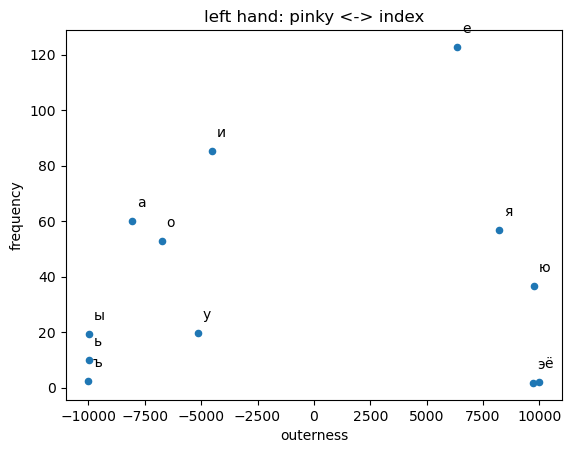

In [5]:
CORP.display_outerness("(t1 == 'v') & (t2 == 'v')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
ц     1.178443    8.174410   -6.995967    9.352852 -7480.035492
щ     0.722004    4.365218   -3.643214    5.087221 -7161.500816
л    23.386280   85.088549  -61.702269  108.474829 -5688.164639
р    49.494597  159.131272 -109.636674  208.625869 -5255.181193
н    62.216800  165.297349 -103.080549  227.514150 -4530.731351
т    98.059719  175.961427  -77.901708  274.021146 -2842.908628
к    44.988299   72.507428  -27.519129  117.495726 -2342.138720
м    23.909111   21.776295    2.132815   45.685406   466.848320
ф     2.431576    2.149413    0.282162    4.580989   615.942029
в    71.270892   60.540424   10.730469  131.811316   814.077945
ш    13.502299   10.647480    2.854819   24.149778  1182.130584
д    56.067321   39.876181   16.191140   95.943501  1687.570279
х     9.145380    5.717937    3.427443   14.863317  2305.974316
ж    20.556358    7.709672   12.846686   28.266029  4544.920728
с   232.908430   83.063619  149.844811  315.972049  4742.343857
г    31.353217   10.572790   20.780428   41.926007  4956.452890
ч    40.614782   12.962871   27.651911   53.577653  5161.090458
п    74.192103   21.021096   53.171007   95.213199  5584.415584
б    28.755664    5.145314   23.610350   33.900978  6964.504284
з    52.457302    4.780162   47.677140   57.237465  8329.708569
й    19.286627    0.008299   19.278328   19.294926  9991.397849

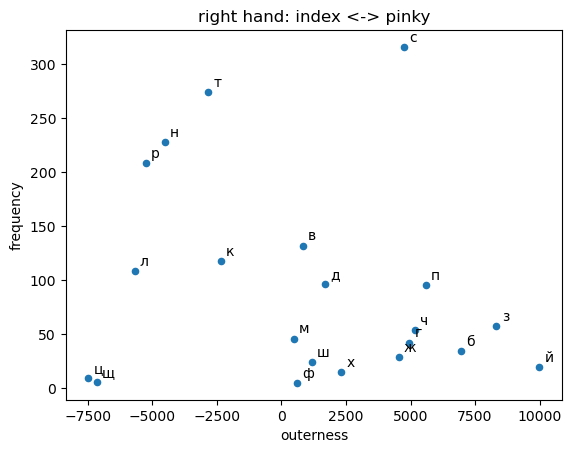

In [6]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [7]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [8]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 abcd3 6ghij99
 01233 667899
e
''', '''
753222 6422369
422003 42002368
 10002 2000125
 12213 312213
0
''',
STANDARD_REACH, std_key_shape, STD_EXTRA_KEYS)


# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [9]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 0abcd3 6ghij9
 001233 6678
e
''',

'''
9752224 422236
7421134 431123
 210002 200012
 421114 4111
0
''',

'''
9753444 573345
6443224 531134
 211122 221112
 310014 4100
0
'''
, std_key_shape, STD_EXTRA_KEYS)


In [10]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32букваП': r'''    
ъ12345 67890-=
→фуыхэ жшвкчзщ/
 поией ,ртнсд¶
 ьаёяю цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест37': r'''
ъ12345 67890-=
→фцыхё шмвкзжэ
 аиое, йртнсч¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест38': r'''
ъ12345 67890-=
→фэыхё жмвкчшц/
 аиое, йртнсз¶
 щьуяю глдпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест39': r'''
ъ12345 67890-=
→фёыхэ шмвкчйц/
 аиое, зртнсг¶
 щьуяю жлдпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    

'тест40': r'''
ъ12345 67890-=
→фцыёэ шмвкзчх/
 аиое, йртнсг¶
 щьуяю жлдпб
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
 
'тест41': r'''
ъ12345 67890-=
→фцыёэ швкдгжх/
 аоие, лрнтсз¶
 щьуяю ймбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест42': r'''
ъ12345 67890-=
→фыцэё шбвдгжх/
 аоие, лрнтсз¶
 щьуяю ймкпч
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест43': r'''
ъ12345 67890-=
→эыцёх шбвдгжф/
 аоие, лрнтсз¶
 щьуяю ймкпч
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест44': r'''
ъ12345 67890-=
→эьуяю шбдвзжф/
 аиое, млтнсг¶
 щыцхё йркпч
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
'''
}

    

In [11]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 11.0859
key "?" repeated: 2
key """ repeated: 2
layout usphonetic: 8.0515
layout rusdvorak: 4.5243
key ":" repeated: 2
layout диктор: 3.8757
layout зубачёв: 3.3293
key "." repeated: 2
layout скоропис: 3.9348
key ";" repeated: 2
key ":" repeated: 2
key """ repeated: 3
layout ант: 4.273
layout ugnvs: 6.3991
layout леонов: 3.2859
layout леонов2: 3.2841
layout леонов3: 3.3955
layout тест1: 8.7452
layout тест2: 8.7769
layout тест3: 6.7985
layout тест4: 5.5538
layout тест5: 4.4313
layout тест6: 4.324
layout тест7: 4.3405
layout тест8: 4.523
layout тест9: 4.5768
layout тест10: 4.0009
layout тест11: 4.1425
layout тест12: 3.9553
layout тест13: 3.985
layout тест14: 3.8731
layout тест15: 3.6208
layout тест16: 3.6362
layout тест17: 3.5669
layout тест18: 3.581
layout тест19: 3.6579
layout тест20: 3.6523
layout тест21: 3.4793
layout тест22: 3.4793
layout тест23: 3.3323
layout тест24: 3.0666
layout тест25: 3.3329
layout ино1: 3.0535
layout тест26: 3.1631
layout тест27: 3.0952
layout ин

# Final Standings <a name="standings">

In [12]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест27', ''),
    ('тест43', 'Best and currently in use on my laptop'),
    ('тест44', 'New version with new scoring'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# ergodox layouts moved to another notebook, see the folder

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   2.637 | Alien #2, many counterparts on AltGr   |
| ино1       |   3.054 | Alien #1, rare letters on AltGr        |
| тест44     |   3.064 | New version with new scoring           |
| тест27     |   3.095 |                                        |
| тест43     |   3.225 | Best and currently in use on my laptop |
| леонов     |   3.286 | Leonov                                 |
| зубачёв    |   3.329 | Zubachov                               |
| диктор     |   3.876 | Dictor                                 |
| скоропис   |   3.935 | Skoropis                               |
| тест10     |   4.001 | First optimized after hand testing     |
| ант        |   4.273 | ANT                                    |
| rusdvorak  |   4.524 | Dvorak translit                        |
| тест9      |   4.577 | First hand-tested       

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000113 66789999
 abcd3 6ghij99
 01233 667899
e
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

тест45 : 3.222 


/usr/lib/python3/dist-packages/IPython/core/events.py:93: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  func(*args, **kwargs)


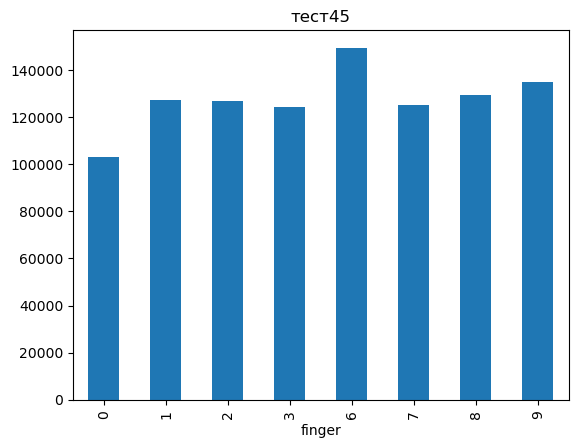

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


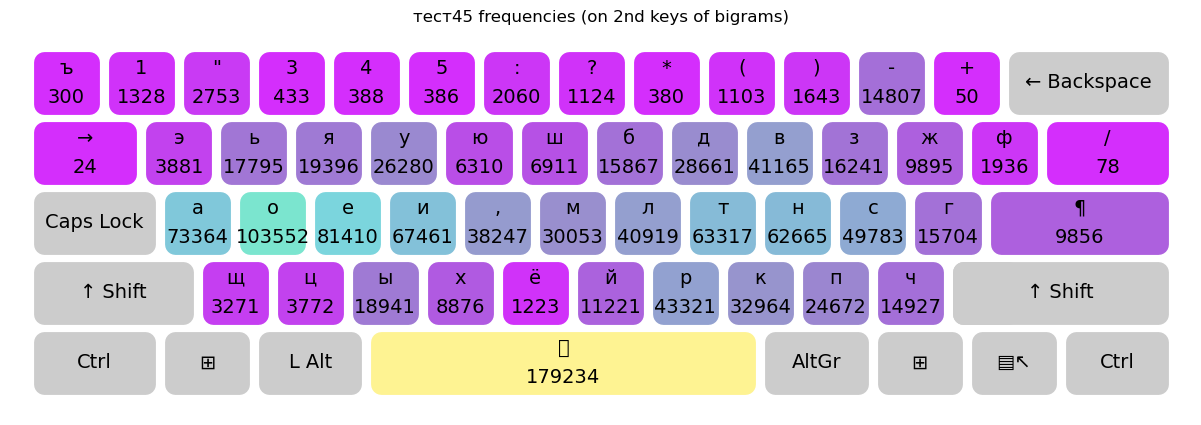

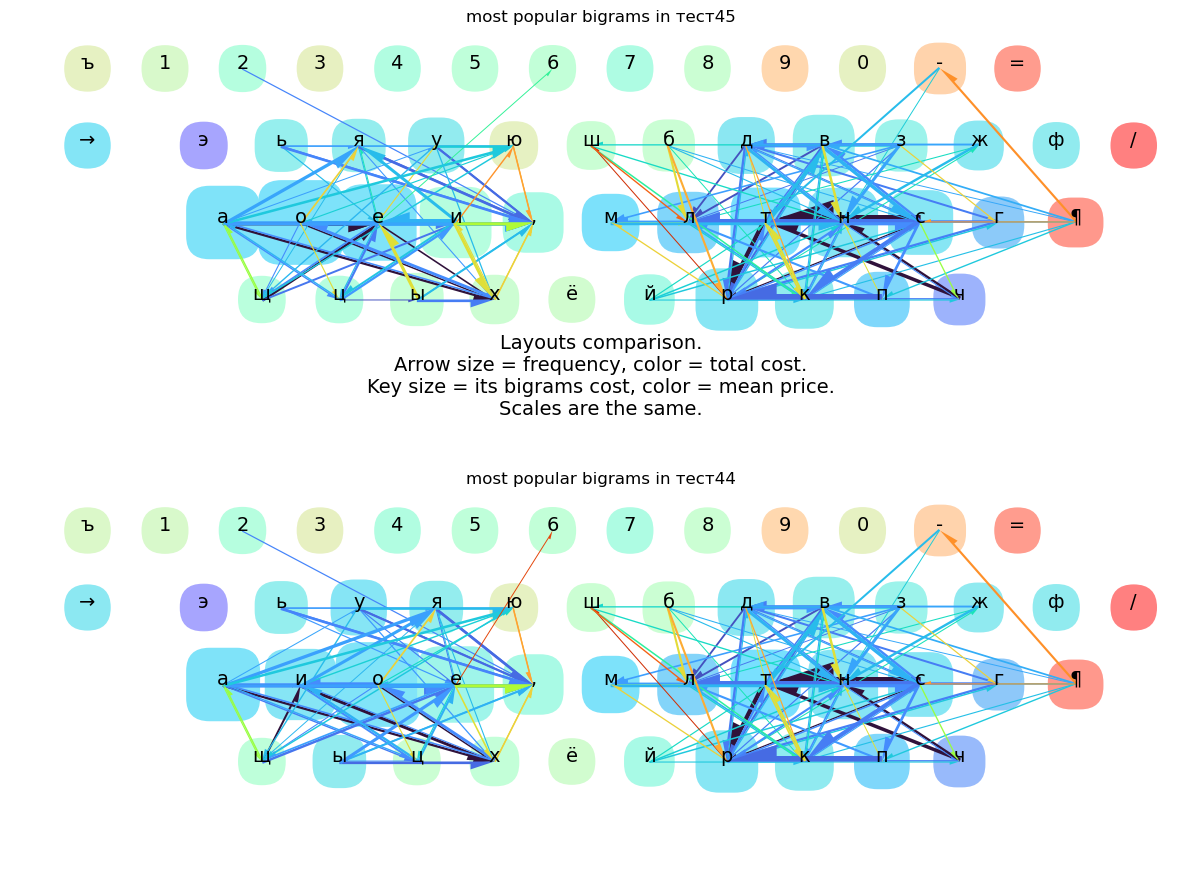

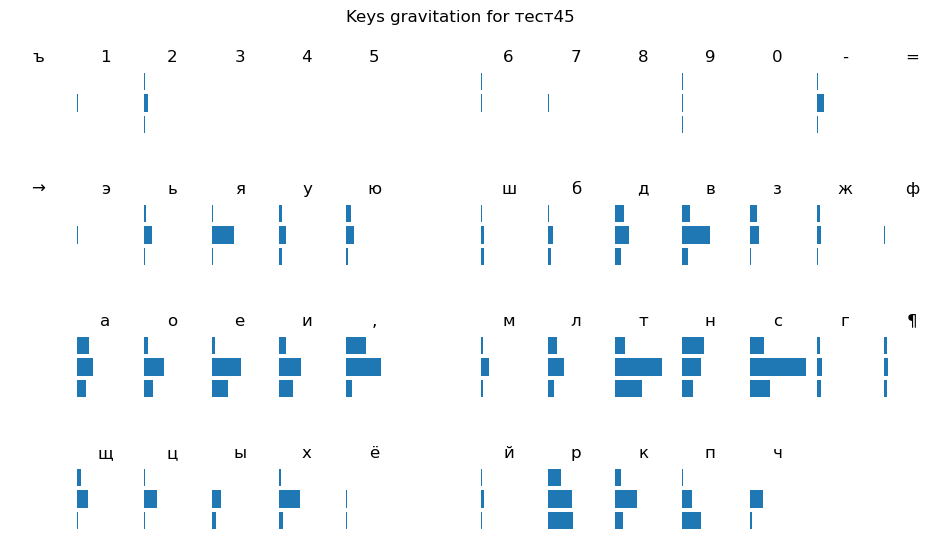

In [13]:
# →щфыхэ цзмквчш/
#  аиоей ,ртнсг¶
#  ьуюяё жлдпб

lyt = Layout('тест45', (r'''
ъ12345 67890-=
→эьяую шбдвзжф/
 аоеи, млтнсг¶
 щцыхё йркпч
⌴

∅!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅\
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

r.load_bars()
r.display('freq')
r.combomap(results['тест44'])
r.display('rows')


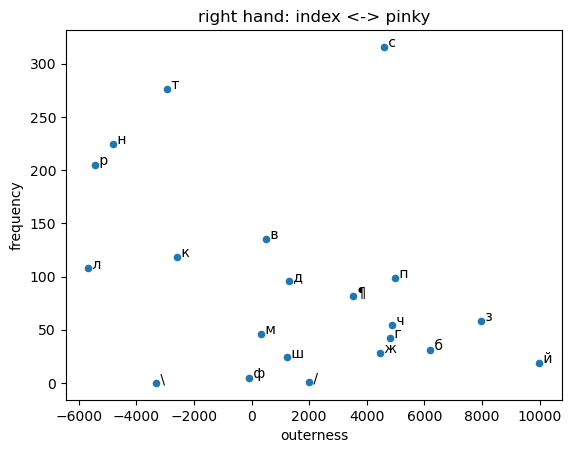

In [14]:
km = r.layout.keyboard.keymap
km = km[(km.hand == 1) & (km.finger != 5) & (km.row > 0)].copy()

d2 = r.bigrams.merge(
    km[['hand', 'finger']], left_on=['row1', 'column1'], right_index=True, suffixes=('', '1')).merge(
    km[['hand', 'finger']], left_on=['row2', 'column2'], right_index=True, suffixes=('', '2'))



t2 = d2.groupby('l1').agg({'freq': 'sum'}).join(d2.groupby('l2').agg({'freq': 'sum'}), how='outer',
                                                lsuffix='_out', rsuffix='_in')
t2.fillna(0, inplace=True)
t2['outer'] = (t2.freq_out - t2.freq_in)
t2['frequency'] = t2.freq_in + t2.freq_out
t2['outerness'] = t2.outer / t2.frequency
t2 *= 10000

t3 = r.bigrams.groupby('l1').agg({'freq': 'sum'}).join(r.bigrams.groupby('l2').agg({'freq': 'sum'}), how='outer',
lsuffix='1', rsuffix='2')
t3['freq'] = t3['freq1'] + t3['freq2']
t2['freq'] = t3['freq']

title = 'right hand: index <-> pinky'
ax = t2[['frequency', 'outerness']].plot.scatter(x='outerness', y='frequency', title=title)
for i, row in t2.iterrows():
    ax.annotate(f' {i}', (row.outerness, row.frequency))

In [15]:
b = CORP.bigrams
b[b.l1 == 'п'].sort_values('num', ascending=False)

bigram   num l1 l2 t1 t2          freq
55       по  9083  п  о  c  v  7.537884e-03
41       пр  7127  п  р  c  c  5.914621e-03
224      пе  2257  п  е  c  v  1.873060e-03
303      па  1437  п  а  c  v  1.192551e-03
160      пи  1378  п  и  c  v  1.143587e-03
252      пл  1062  п  л  c  c  8.813424e-04
436      пу   912  п  у  c  v  7.568590e-04
445      пы   291  п  ы  c  v  2.414978e-04
606      пя   253  п  я  c  v  2.099620e-04
824      пн   224  п  н  c  c  1.858952e-04
1303     пк   111  п  к  c  c  9.211771e-05
471      пп   108  п  п  c  c  8.962804e-05
782      пт   107  п  т  c  c  8.879815e-05
1873     пс   102  п  с  c  c  8.464871e-05
958      п⌴    55  п  ⌴  c  -  4.564391e-05
1804     пь    45  п  ь  c  v  3.734502e-05
733      пц    35  п  ц  c  c  2.904613e-05
1777     пч    28  п  ч  c  c  2.323690e-05
2535     пм    15  п  м  c  c  1.244834e-05
2387     п.    12  п  .  c  -  9.958672e-06
924      п,    12  п  ,  c  -  9.958672e-06
1066     пз    11  п  з  c  c  9.128782e-06
1548     пё     7  п  ё  c  v  5.809225e-06
1556     пш     6  п  ш  c  c  4.979336e-06
2479     п"     4  п  "  c  -  3.319557e-06
2573     п-     2  п  -  c  -  1.659779e-06
2096     пд     2  п  д  c  c  1.659779e-06
2317     пг     1  п  г  c  c  8.298893e-07
2455     п'     1  п  '  c  -  8.298893e-07
2520     п)     1  п  )  c  -  8.298893e-07
1463     пб     1  п  б  c  c  8.298893e-07
2555     п!     1  п  !  c  -  8.298893e-07
1880     пэ     1  п  э  c  v  8.298893e-07

In [16]:
r.bigrams[r.bigrams.l2 == 'л'].sort_values('num', ascending=False)

bigram   num l1 l2 t1 t2          freq  row1  column1  row2  ...  \
93       ал  6648  а  л  v  c  5.517104e-03     2        1     2  ...   
88       ол  6459  о  л  v  c  5.360255e-03     2        2     2  ...   
45       ел  6391  е  л  v  c  5.303822e-03     2        3     2  ...   
24       ил  4248  и  л  v  c  3.525370e-03     2        4     2  ...   
57       сл  2912  с  л  c  c  2.416638e-03     2       11     2  ...   
6        ⌴л  2872  ⌴  л  -  c  2.383442e-03     4        0     2  ...   
226      ыл  1647  ы  л  v  c  1.366828e-03     3        3     2  ...   
347      ул  1488  у  л  v  c  1.234875e-03     1        4     2  ...   
491      гл  1141  г  л  c  c  9.469037e-04     2       12     2  ...   
252      пл  1062  п  л  c  c  8.813424e-04     3       10     2  ...   
346      бл  1031  б  л  c  c  8.556159e-04     1        8     2  ...   
338      вл   897  в  л  c  c  7.444107e-04     1       10     2  ...   
500      дл   781  д  л  c  c  6.481435e-04     1        9     2  ...   
363      кл   692  к  л  c  c  5.742834e-04     3        9     2  ...   
97       ял   575  я  л  v  c  4.771863e-04     1        3     2  ...   
285      шл   434  ш  л  c  c  3.601720e-04     1        7     2  ...   
794      мл   274  м  л  c  c  2.273897e-04     2        7     2  ...   
530      лл   245  л  л  c  c  2.033229e-04     2        8     2  ...   
535      тл   209  т  л  c  c  1.734469e-04     2        9     2  ...   
568      зл   208  з  л  c  c  1.726170e-04     1       11     2  ...   
665      хл   143  х  л  c  c  1.186742e-04     3        4     2  ...   
323      эл   113  э  л  v  c  9.377749e-05     1        1     2  ...   
421      рл   103  р  л  c  c  8.547860e-05     3        8     2  ...   
957      -л    63  -  л  -  c  5.228303e-05     0       12     2  ...   
567      ёл    58  ё  л  v  c  4.813358e-05     3        5     2  ...   
1493     ¶л    56  ¶  л  -  c  4.647380e-05     2       13     2  ...   
1041     фл    47  ф  л  c  c  3.900480e-05     1       13     2  ...   
1314     йл    40  й  л  c  c  3.319557e-05     3        7     2  ...   
864      "л    20  "  л  -  c  1.659779e-05     0        2     2  ...   
2331     юл    19  ю  л  v  c  1.576790e-05     1        5     2  ...   
1252     чл    15  ч  л  c  c  1.244834e-05     3       11     2  ...   
1388     жл    11  ж  л  c  c  9.128782e-06     1       12     2  ...   
1328     (л     8  (  л  -  c  6.639114e-06     0       10     2  ...   
1335     нл     7  н  л  c  c  5.809225e-06     2       10     2  ...   
590      цл     1  ц  л  c  c  8.298893e-07     3        2     2  ...   
2373     .л     1  .  л  -  c  8.298893e-07     2        5     2  ...   

      rollout  k2penalty row  column finger  ftype  hand  penalty  reach  \
93          0          1   2       8      6      1     1        0      2   
88          0          1   2       8      6      1     1        0      2   
45          0          1   2       8      6      1     1        0      2   
24          0          1   2       8      6      1     1        0      2   
57          0          1   2       8      6      1     1        0      2   
6           0          1   2       8      6      1     1        0      2   
226         0          1   2       8      6      1     1        0      2   
347         0          1   2       8      6      1     1        0      2   
491         0          1   2       8      6      1     1        0      2   
252         0          1   2       8      6      1     1        0      2   
346         0          1   2       8      6      1     1        0      2   
338         0          1   2       8      6      1     1        0      2   
500         0          1   2       8      6      1     1        0      2   
363         0          1   2       8      6      1     1        0      2   
97          0          1   2       8      6      1     1        0      2   
285         0          1   2       8      6      1     1        0      2   
794        

check which side and row letters gravitate to in a layout result (this depends on corpus stats, hence it should be done in a Result instance)


## Finger Load Comparison <a name='finger-load'/>

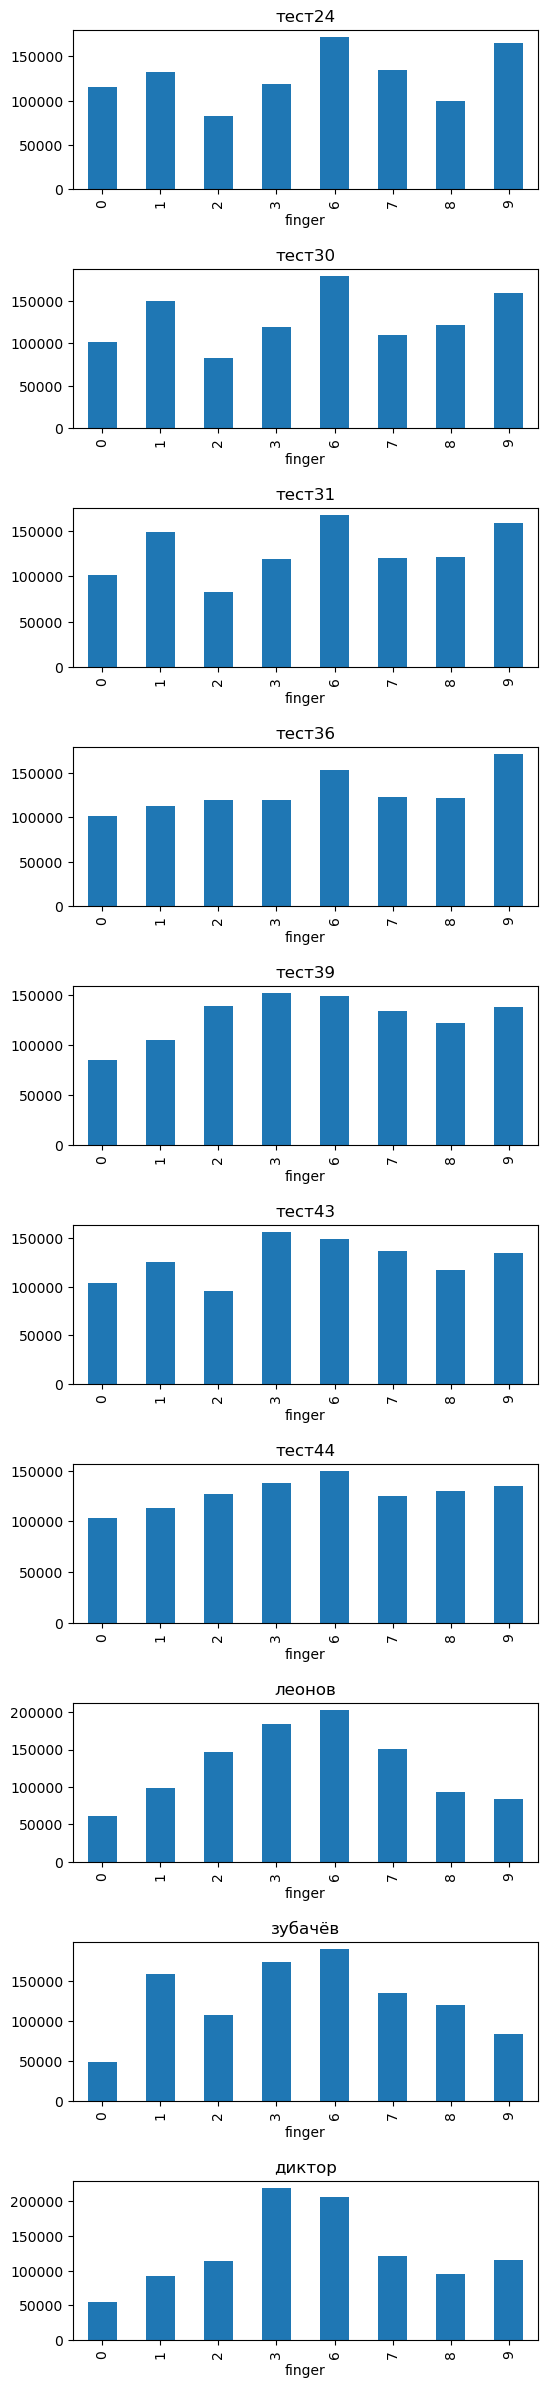

In [17]:
keys = ('тест24', 'тест30', 'тест31', 'тест36', 'тест39', 'тест43', 'тест44', 'леонов', 'зубачёв', 'диктор')
from matplotlib import pyplot as plt
fig, axs = plt.subplots(len(keys), 1, figsize=(6, 3 * len(keys)))
plt.subplots_adjust(hspace=.5)

for k, ax in zip(keys, axs):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d.plot.bar(ax=ax, title=k, legend=False)

## Which Rows do Keys Gravitate to <a name='rows-gravitation'>
    
In this chart, we show how many bigrams do letters have with rows 1-3 (main key rows). If a key in bottom row has most bigrams in bottom or middle row, it's fine in that position. This chart actually shows that almost all letters are in their best places.
    
note: This calculation excludes combos with keys on another hand, and with the key itself (НН is quite popular that it distorts the stats significantly).

Letter В (v) may gain a little bit in the bottom row, but letters in that row will loose more.

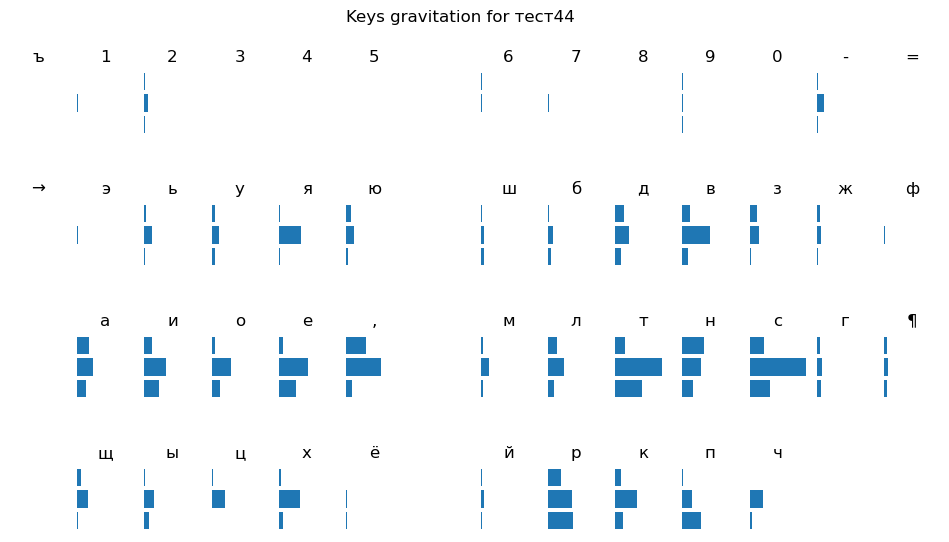

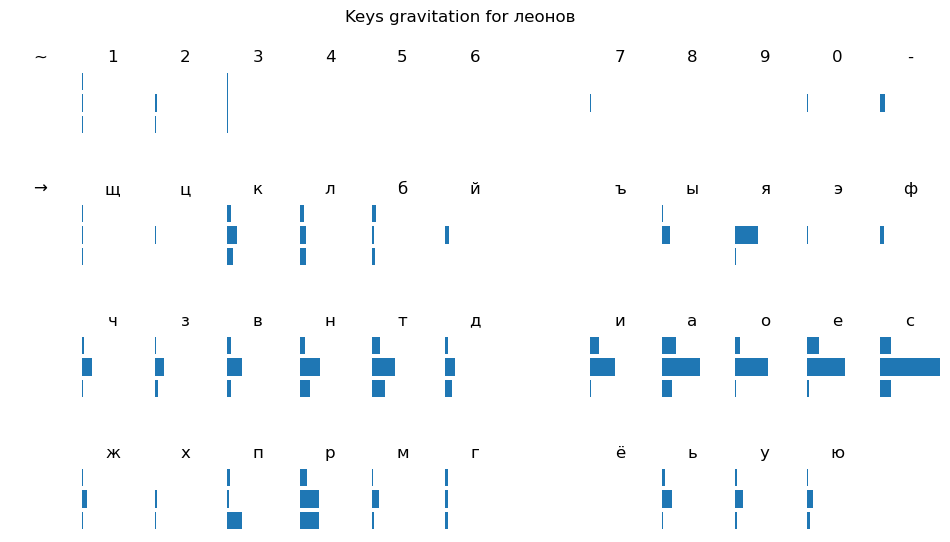

In [18]:
results['тест44'].display('rows')
results['леонов'].display('rows')

# Bigrams vs Position Penalties <a name='bigram-position-chart'/>

### Theoretical minimal score

This calculation shows how low could the score be if we put keys ordered by frequencies, and there were no bigrams penalties:

In [19]:
pos_penalties = STANDARD_KBD.keymap['penalty'].values
pos_penalties.sort()
freqs = CORP.bigrams.groupby('l2').agg({'freq': 'sum'}).sort_values('freq', ascending=False).values
min_score = sum(a * b for a, b in zip(freqs, pos_penalties))[0]
min_score

0.0

name    row    col    pos  rollout    cost  coord  pareto_opt
0       йцукен  2.723  0.196  1.829    0.174  11.086  3.093       False
1   usphonetic  1.729  0.162  1.722    0.205   8.052  2.096       False
2    rusdvorak  0.897  0.086  1.123    0.134   4.524  1.117       False
3       диктор  0.735  0.071  1.176    0.088   3.876  0.894       False
4      зубачёв  0.592  0.040  1.111    0.091   3.329  0.723       False
5          ант  0.635  0.122  1.444    0.170   4.273  0.927       False
6        ugnvs  1.359  0.183  1.207    0.187   6.399  1.729       False
7       леонов  0.508  0.072  0.956    0.166   3.286  0.746       False
8        тест1  1.997  0.171  1.778    0.158   8.745  2.326       False
18      тест11  0.729  0.088  1.500    0.070   4.143  0.887       False
31      тест24  0.568  0.050  1.006    0.065   3.067  0.683        True
34      тест27  0.571  0.055  1.021    0.063   3.095  0.689       False
37      тест30  0.581  0.067  0.948    0.069   3.098  0.717        True
38      тест31  0.607  0.067  0.938    0.068   3.165  0.742        True
39      тест32  0.618  0.072  0.962    0.083   3.293  0.773       False
44      тест36  0.604  0.068  0.929    0.072   3.168  0.744        True
46      тест38  0.667  0.082  0.940    0.068   3.379  0.817       False
47      тест39  0.645  0.078  0.932    0.070   3.303  0.793       False
48      тест40  0.623  0.066  0.958    0.067   3.226  0.756       False
49      тест41  0.569  0.082  0.992    0.064   3.119  0.715       False
50      тест42  0.580  0.082  0.979    0.063   3.136  0.725       False
51      тест43  0.600  0.096  0.971    0.066   3.225  0.762       False
52      тест44  0.554  0.075  0.972    0.070   3.064  0.699        True

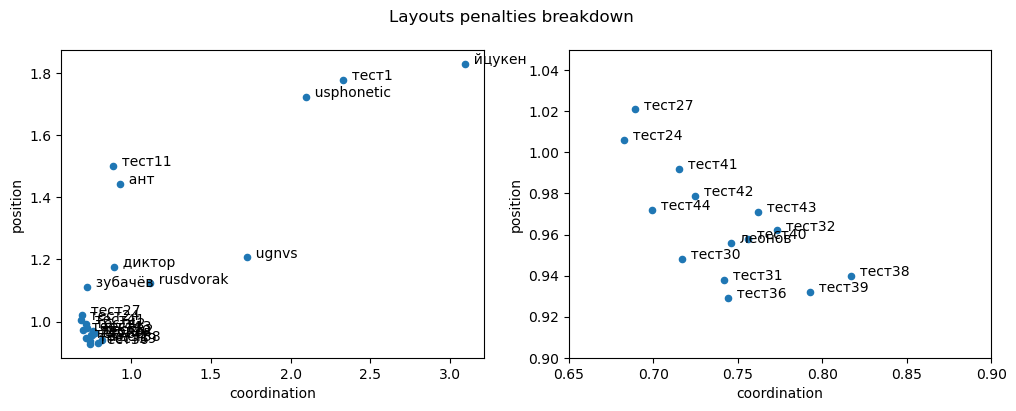

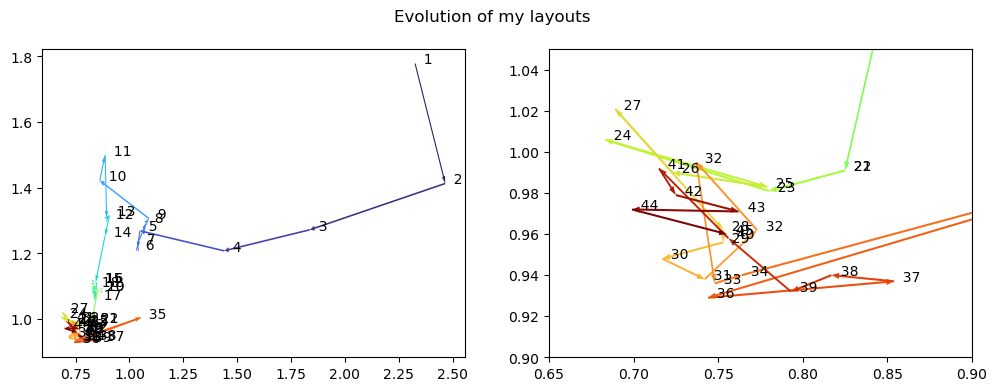

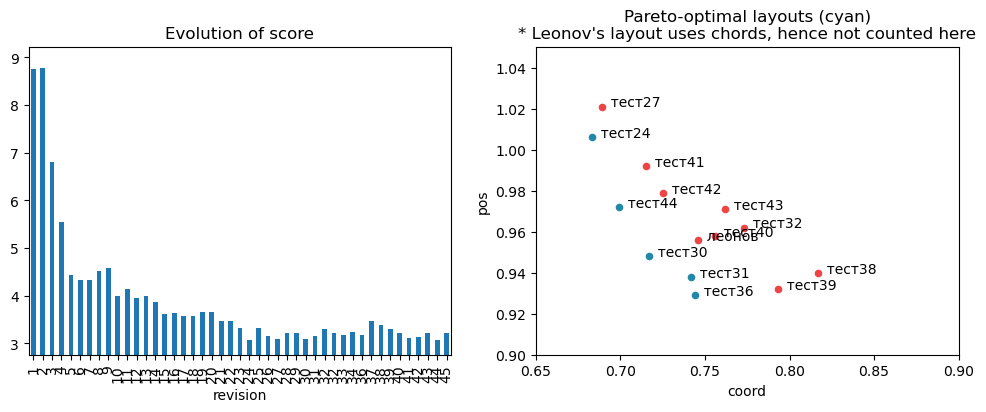

In [20]:
xlims = (.65, .9)
ylims = (.9, 1.05)

dd = []
for k, v in results.items():
#    if k.startswith('тест') and not k.startswith('тест37'): continue
    if k.startswith('леонов') and not k == 'леонов': continue
    if k.startswith('ино'): continue
    if k.startswith('скоропис'): continue
    b = results[k].bigrams
    bgcost = b.cost
    dd.append({
        'name': k, 
        'row': round((b.row_cost * b.num).sum() / b.num.sum(), 3),
        'col': round((b.col_cost * b.num).sum() / b.num.sum(), 3),
        'pos': round((b.k2penalty * b.num).sum() / b.num.sum(), 3),
        'rollout': round((b.rollout * b.num).sum() / b.num.sum(), 3),
        'cost': round(bgcost.sum() / b.num.sum(), 3)
    })
    
df2 = pd.DataFrame(dd)
df2['coord'] = df2['row'] + df2['col'] + df2['rollout']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
lims = (0.6, 1.0)
# selecting layouts to display their scores
df3 = df2[~df2.name.str.startswith('тест') | df2.name.isin([
    'тест44', 'тест43', 'тест42', 'тест41', 'тест40', 'тест39', 'тест38', 'тест36', 'тест32', 'тест31', 'тест30', 'тест27', 'тест24', 'тест1', 'тест11'])].copy()
for ax in (ax1, ax2):
    df3.plot.scatter(x='coord', y='pos', ax=ax)
    for i, rw in df3.iterrows():
        ax.annotate('  ' + str(rw['name']), (rw.coord, rw.pos))

    for a in (ax1, ax2):
        a.set_xlabel('coordination')
        a.set_ylabel('position')

ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)
        
fig.suptitle('Layouts penalties breakdown')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Evolution of my layouts')

import re
df4 = df2[df2.name.apply(lambda k: re.match(r'тест(\d+)', k) is not None)].copy()
df4['revision'] = df4.name.apply(lambda k: int(re.match(r'тест(\d+)', k).groups()[0]))
df4.sort_values('revision', inplace=True)
df4['coord1'] = df4.coord.diff(-1)
df4['pos1'] = df4.pos.diff(-1)
maxnum = df4.revision.max() - 1

for ax, w in zip((ax1, ax2), (.005, .001)):
    a.set_xlabel('coordination')
    a.set_ylabel('position')
    for _, rw in df4.iterrows():
        ax.arrow(
            rw['coord'], rw['pos'], -rw['coord1'], -rw['pos1'],
            width=w,
            length_includes_head=True, ec='#00000000',
            color=plt.cm.turbo(rw.revision / maxnum)
        )
        ax.annotate(f'  {rw["revision"]}', (rw['coord'], rw['pos']))

ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df5 = df4[df4.revision != 35].set_index('revision')
scores = df5['cost']
scores.plot.bar(ax=ax1, title='Evolution of score')
ax1.set_ylim(scores.min() * .9, scores.max() * 1.05)

df3['pareto_opt'] = df3.apply(lambda row: len(df3[(df3.coord < row.coord) & (df3.pos < row.pos) & (df3.name != 'леонов')]) == 0, axis=1)

df3[df3.pareto_opt].plot.scatter(x='coord', y='pos', color='#2288aa', marker='o', ax=ax2)
df3[~df3.pareto_opt].plot.scatter(x='coord', y='pos', color='#ee4444', marker='o', ax=ax2)
for _, rw in df3.iterrows():
    ax2.annotate(f'  {rw["name"]}', (rw['coord'], rw['pos']))

ax2.set_title('Pareto-optimal layouts (cyan)\n* Leonov\'s layout uses chords, hence not counted here')
ax2.set_xlim(*xlims)
ax2.set_ylim(*ylims)

df3

#### How to read the charts above:

* Layout penalties
    * dots on the left have more convenient roll-ins (or alternating hands
    * dots in the bottom have fingers work more in home position
* Evolution of my layouts: dimensions are the same
    * notice: the criteria for convenience were different.
    * some layouts move up-left -- these were optimizations of bigrams that turned out worse in real testing, because some awkward position wasn't penalized.
* Evolution of score (bottom)
    * Local peaks were revisions where improvement of score made the layout noteably worse in typing test. Score rules were then updated, and after that, the revision scored worse than previous ones.

Notes:

1. A complete improvement (within the scoring system) is when a layout is both lower and to the left of the other one.
2. If two layouts are on a line from left-up to right-down, then they have tradeoffs, none is better.
3. The best layouts are 41, 42, 39 and 32 (if we exclude `леонов` that uses chords). All other layouts are worse than theese (they have both scores worse).
4. Scores started to be changed starting from layout 10.
5. Layout 35 was an attempt to move vowels on the right side.
6. Leonov's layout has comma and period on chords, hence it spares a good deal of penalty (costs of chording aren't calculated).



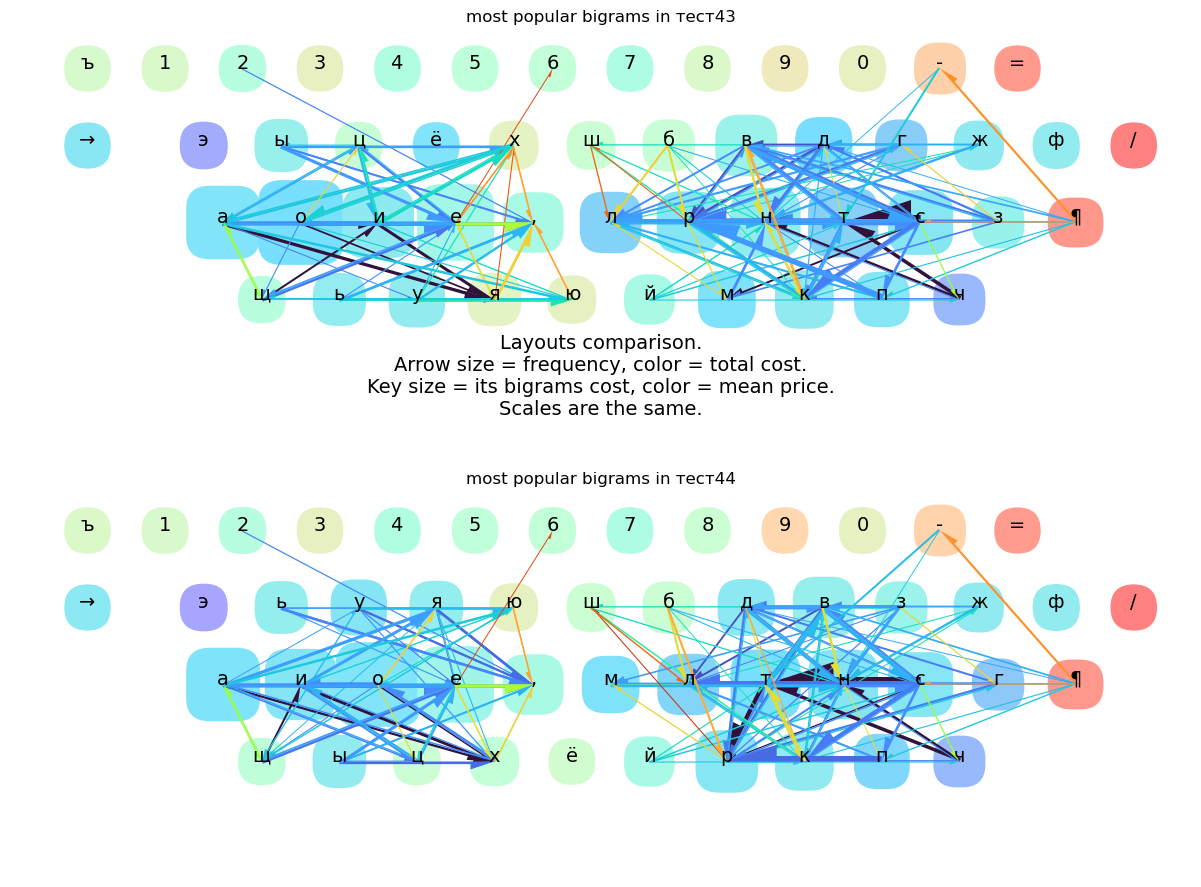

In [21]:
results['тест43'].combomap(results['тест44'])

# Export Your Or Other Layout to Linux xkb <a name='export-to-xkb'/>

Run the next cell, and it will output layout variant block. You should copy and paste it into some `/usr/share/X11/xkb/symbols/*` file. To show it in layouts, add it to `/usr/share/X11/xkb/rules/evdev.xml`:

```
    <layout>
      <configItem>
        <name>[name of the file in symbols]</name>
        <shortDescription>ru</shortDescription>
        <description>Russian</description>
        <countryList>
          <iso3166Id>RU</iso3166Id>
          <iso3166Id>KZ</iso3166Id>
        </countryList>
        <languageList>
          <iso639Id>rus</iso639Id>
        </languageList>
      </configItem>
      <variantList>
        <variant>
          <configItem>
            <name>[the same name as in xkb_symbols "<name>"]</name>
            <description>[title]</description>
          </configItem>
        </variant>
      </variantList>
    </layout>
```

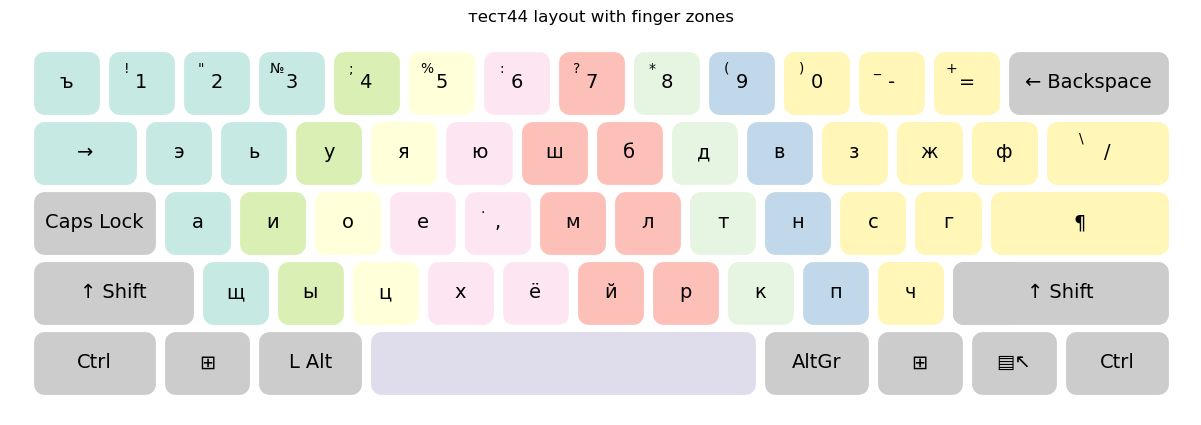

In [22]:
results['тест44'].layout.display()

In [23]:
results['тест44'].layout.export()


default partial alphanumeric_keys
xkb_symbols "тест44" {
	include "ru(common)"
	name[Group1]= "Culebron (тест44)";
	
	key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };


	key <AD01> { [ Cyrillic_e, Cyrillic_E ] };
	key <AD02> { [ Cyrillic_softsign, Cyrillic_SOFTSIGN ] };
	key <AD03> { [ Cyrillic_u, Cyrillic_U ] };
	key <AD04> { [ Cyrillic_ya, Cyrillic_YA ] };
	key <AD05> { [ Cyrillic_yu, Cyrillic_YU ] };
	key <AD06> { [ Cyrillic_sha, Cyrillic_SHA ] };
	key <AD07> { [ Cyrillic_be, Cyrillic_BE ] };
	key <AD08> { [ Cyrillic_de, Cyrillic_DE ] };
	key <AD09> { [ Cyrillic_ve, Cyrillic_VE ]

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

bigram   num              row_cat_old  row_cost_old           col_cat_old  \
143     кт  1253                                    1.0                    ok   
96      оя   711                                    0.0                    ok   
307     тк   626                                    1.0                    ok   
25      ⌴м  7503        alternating hands           0.0  alternating or space   
453     дк   352                                    2.0                    ok   
138     я⌴  9423                    thumb           0.0                    ok   
191     ом  5523        alternating hands           0.0  alternating or space   
39      ь⌴  7467                    thumb           0.0                    ok   
324     бр  1031  same finger change rows          15.0                    ok   
277     ая  2509                                    0.0                    ok   
262     ия  2162                                    0.0                    ok   
102     ем  4175        alternating hands           0.0  alternating or space   
49      тв  2554                                    1.0                    ok   
299     ам  3305        alternating hands           0.0  alternating or space   
106     им  3164        alternating hands           0.0  alternating or space   
351     вп   189                                    2.0                    ok   
781     пн   224                                    1.0                    ok   
104     у⌴  4242                    thumb           0.0                    ok   
411     дн  2087                                    1.0                    ok   
38      ть  6899        alternating hands           0.0  alternating or space   
906     ёх    93                                    2.0                    ok   
152     мн  1740                                    0.0                    ok   
14      тн  1479                                    0.0                    ok   
46      ль  5330        alternating hands           0.0  alternating or space   
196     зн  2125                                    0.5                    ok   
94      ⌴з  4910        alternating hands           0.0  alternating or space   
257     ои  1134                                    0.0                    ok   
618     яц    87                                    1.0                    ok   
381     см   863                                    0.0                    ok   
737     её    73                                    0.0                    ok   

     col_cost_old  k2penalty_old  rollout_old  cost_old  \
143           0.0              0            1    8771.0   
96            0.0              0            0       0.0   
307           0.0              1            0    2504.0   
25            0.0              0            0       0.0   
453           0.0              1            0    2464.0   
138           0.0              1            0    9423.0   
191           0.0              0            0       0.0   
39            0.0              1            0    7467.0   
324           0.0              1            0   47426.0   
277           0.0              0            0       0.0   
262           0.0              0            0       0.0   
102           0.0              0            0       0.0   
49            0.0              1            0   10216.0   
299           0.0              0            0       0.0   
106           0.0              0            0       0.0   
351           0.0              1            1    2079.0   
781           0.0              0            0     672.0   
104           0.0              1            0    4242.0   
411           0.0              0            0    6261.0   
38            0.0              1            0    6899.0   
906           0.0              4            0     930.0   
152           0.0              0            1    6960.0   
14            0.0              0            0       0.0   
46            0.0              1            0    5330.0   
196           1.0

/usr/lib/python3/dist-packages/IPython/core/events.py:93: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  func(*args, **kwargs)
/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


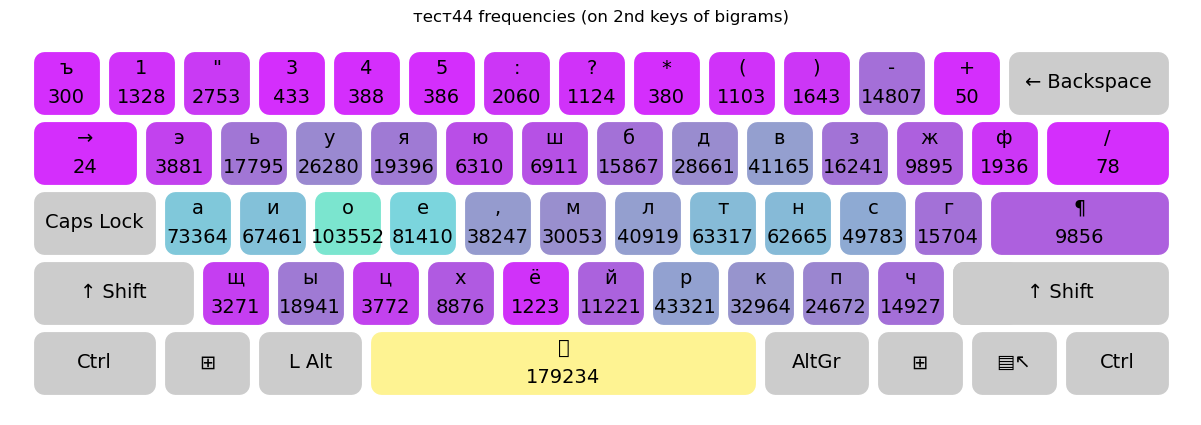

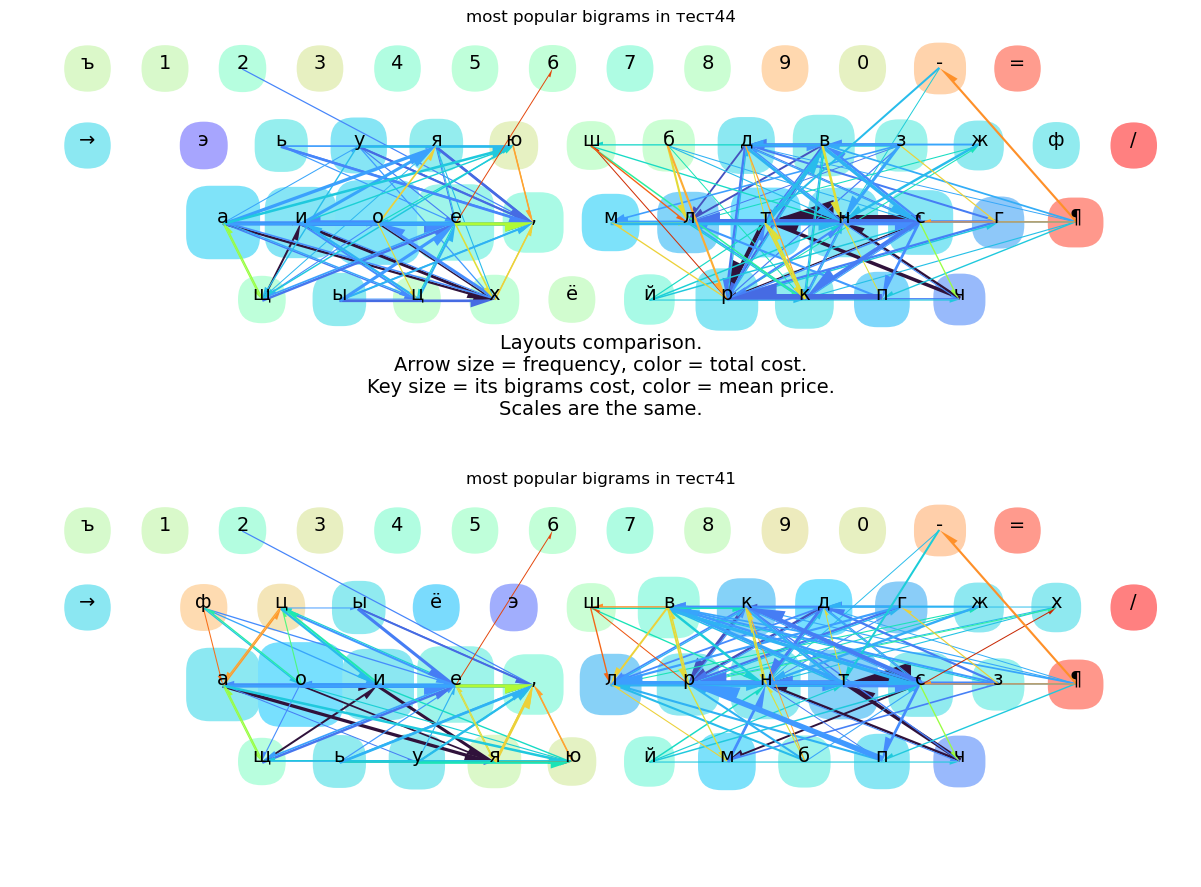

In [24]:
k = 'тест44'
results[k].display('num')
results[k].combomap(results['тест41'])
results['тест43'].compare(results[k]).sort_values('delta', ascending=False).head(30)

## Losses

In [25]:
key = 'тест44'

In [26]:
compare(results, 'тест43', key).head(30)

bigram   num              row_cat_old  row_cost_old           col_cat_old  \
143     кт  1253                                    1.0                    ok   
96      оя   711                                    0.0                    ok   
307     тк   626                                    1.0                    ok   
25      ⌴м  7503        alternating hands           0.0  alternating or space   
453     дк   352                                    2.0                    ok   
138     я⌴  9423                    thumb           0.0                    ok   
191     ом  5523        alternating hands           0.0  alternating or space   
39      ь⌴  7467                    thumb           0.0                    ok   
324     бр  1031  same finger change rows          15.0                    ok   
277     ая  2509                                    0.0                    ok   
262     ия  2162                                    0.0                    ok   
102     ем  4175        alternating hands           0.0  alternating or space   
49      тв  2554                                    1.0                    ok   
299     ам  3305        alternating hands           0.0  alternating or space   
106     им  3164        alternating hands           0.0  alternating or space   
351     вп   189                                    2.0                    ok   
781     пн   224                                    1.0                    ok   
104     у⌴  4242                    thumb           0.0                    ok   
411     дн  2087                                    1.0                    ok   
38      ть  6899        alternating hands           0.0  alternating or space   
906     ёх    93                                    2.0                    ok   
152     мн  1740                                    0.0                    ok   
14      тн  1479                                    0.0                    ok   
46      ль  5330        alternating hands           0.0  alternating or space   
196     зн  2125                                    0.5                    ok   
94      ⌴з  4910        alternating hands           0.0  alternating or space   
257     ои  1134                                    0.0                    ok   
618     яц    87                                    1.0                    ok   
381     см   863                                    0.0                    ok   
737     её    73                                    0.0                    ok   

     col_cost_old  k2penalty_old  rollout_old  cost_old  \
143           0.0              0            1    8771.0   
96            0.0              0            0       0.0   
307           0.0              1            0    2504.0   
25            0.0              0            0       0.0   
453           0.0              1            0    2464.0   
138           0.0              1            0    9423.0   
191           0.0              0            0       0.0   
39            0.0              1            0    7467.0   
324           0.0              1            0   47426.0   
277           0.0              0            0       0.0   
262           0.0              0            0       0.0   
102           0.0              0            0       0.0   
49            0.0              1            0   10216.0   
299           0.0              0            0       0.0   
106           0.0              0            0       0.0   
351           0.0              1            1    2079.0   
781           0.0              0            0     672.0   
104           0.0              1            0    4242.0   
411           0.0              0            0    6261.0   
38            0.0              1            0    6899.0   
906           0.0              4            0     930.0   
152           0.0              0            1    6960.0   
14            0.0              0            0       0.0   
46            0.0              1            0    5330.0   
196           1.0

## Gains

In [27]:
compare(results, 'тест43', key).tail(30)

bigram   num              row_cat_old  row_cost_old  \
648      у,  1109                               1.333333   
142      х,   520  same finger change rows     20.000000   
69       ор  6982        alternating hands      0.000000   
72       х⌴  3625                    thumb      0.000000   
158      ы⌴  3851                    thumb      0.000000   
378      ую  1288                               2.666667   
57       сл  2912                               0.400000   
466      ея   224  same finger change rows     15.000000   
31       кр  2079                               2.000000   
1021     я:    96  same finger change rows     30.000000   
24       ил  4248        alternating hands      0.000000   
247      иц   882                               2.000000   
596      яе   252  same finger change rows     15.000000   
274      ах  1203                               1.200000   
141      ех   597  same finger change rows     20.000000   
78       тр  4206                               0.666667   
45       ел  6391        alternating hands      0.000000   
88       ол  6459        alternating hands      0.000000   
93       ал  6648        alternating hands      0.000000   
194      хо  2053                               1.500000   
318      кн   363  same finger change rows     15.000000   
880      яю   216  same finger change rows     25.000000   
448      вк   302  same finger change rows     20.000000   
473      ях   278  same finger change rows     25.000000   
312      нк   506  same finger change rows     15.000000   
41       пр  7127                               1.333333   
111      их  2015                               2.000000   
460      кв   493  same finger change rows     20.000000   
350      я.  1067  same finger change rows     15.000000   
132      я,  1664  same finger change rows     15.000000   

               col_cat_old  col_cost_old  k2penalty_old  rollout_old  \
648                     ok           1.0              2            0   
142                     ok           0.0              2            0   
69    alternating or space           0.0              1            0   
72                      ok           1.0              1            0   
158                     ok           1.0              1            0   
378                     ok           1.0              4            0   
57                      ok           1.0              2            0   
466                     ok           0.0              0            0   
31                      ok           0.0              1            0   
1021                    ok           3.0              7            0   
24    alternating or space           0.5              2            0   
247                     ok           1.0              2            1   
596                     ok           0.0              1            0   
274                     ok           1.0              4            0   
141                     ok           1.0              4            0   
78                      ok           0.0              1            0   
45    alternating or space           0.5              2            0   
88    alternating or space           0.5              2            0   
93    alternating or space           0.5              2            0   
194                     ok           1.0              0            1   
318                     ok           0.0              0            0   
880                     ok           1.0              4            0   
448                     ok           0.0              1            0   
473                     ok           1.0              4            0   
312                     ok           0.0              1            0   
41                      ok           0.0              1            0   
111                     ok           1.0              4            0   
460                     ok           0.0              1            0   
350                     ok           1.0              2 

You can save the comparison table to CSV:

In [28]:
compare(results, 'леонов', key).to_csv('leonov-test44.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [29]:
results[key].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram    num l1 l2 t1 t2      freq  row1  column1  row2  ...  rollout  \
125     --   5731  -  -  -  -  0.004756     0       12     0  ...        0   
53      ¶¶   3004  ¶  ¶  -  -  0.002493     2       13     2  ...        0   
358     нн   3403  н  н  c  c  0.002824     2       10     2  ...        0   
272     е,   2285  е  ,  v  -  0.001896     2        4     2  ...        0   
610     ..   2335  .  .  -  -  0.001938     2        5     2  ...        0   
802     ¶-   1075  ¶  -  -  -  0.000892     2       13     0  ...        0   
75      ,⌴  21854  ,  ⌴  -  -  0.018136     2        5     4  ...        0   
186     вн   1452  в  н  c  c  0.001205     1       10     2  ...        0   
324     бр   1031  б  р  c  c  0.000856     1        8     3  ...        0   
143     кт   1253  к  т  c  c  0.001040     3        9     2  ...        0   
346     бл   1031  б  л  c  c  0.000856     1        8     2  ...        0   
23      ⌴и  11777  ⌴  и  -  v  0.009774     4        0     2  ...        1   
261     ее   1425  е  е  v  v  0.001183     2        4     2  ...        0   
365     е.   1232  е  .  v  -  0.001022     2        4     2  ...        0   
89      ⌴о   9887  ⌴  о  -  v  0.008205     4        0     2  ...        1   
201     сс   1254  с  с  c  c  0.001041     2       11     2  ...        0   
29      ии   1200  и  и  v  v  0.000996     2        2     2  ...        0   
96      оя    711  о  я  v  v  0.000590     2        3     1  ...        0   
285     шл    434  ш  л  c  c  0.000360     1        7     2  ...        0   
425     ю,    521  ю  ,  v  -  0.000432     1        5     2  ...        0   
149     .⌴   9908  .  ⌴  -  -  0.008223     2        5     4  ...        0   
307     тк    626  т  к  c  c  0.000520     2        9     3  ...        0   
138     я⌴   9423  я  ⌴  v  -  0.007820     1        4     4  ...        0   
141     ех    597  е  х  v  c  0.000495     2        4     3  ...        0   
142     х,    520  х  ,  c  -  0.000432     3        4     2  ...        0   
182     ⌴э   3333  ⌴  э  -  v  0.002766     4        0     1  ...        1   
434     рш    240  р  ш  c  c  0.000199     3        8     1  ...        0   
25      ⌴м   7503  ⌴  м  -  c  0.006227     4        0     2  ...        0   
39      ь⌴   7467  ь  ⌴  v  -  0.006197     1        2     4  ...        0   
124     ⌴-   5415  ⌴  -  -  -  0.004494     4        0     0  ...        0   

     k2penalty row  column finger  ftype  hand  penalty  reach      cost  
125          5   0      12      9      4     1        0      5  200585.0  
53           4   2      13      9      4     1        0      3  102136.0  
358          0   2      10      8      3     1        0      1  102090.0  
272          2   2       5      3      1     0        0      2   77690.0  
610          2   2       5      3      1     0        0      2   74720.0  
802          5   0      12      9      4     1        0      5   72025.0  
75           1   4       0      4      0     0        0      0   65562.0  
186          0   2      10      8      3     1        0      1   65340.0  
324          0   3       8      6      1     1        0      1   61860.0  
143          0   2       9      7      2     1        0      1   56385.0  
346          1   2       8      6      1     1        0      2   47426.0  
23           0   2       2      1      3     0        0      1   47108.0  
261          1   2       4      3      1     0        0      2   44175.0  
365          2   2       5      3      1     0        0      2   41888.0  
89           0   2       3      2      2     0        0      1   39548.0  
201          0   2      11      9      4     1        0      1   37620.0  
29           0   2       2      1      3     0        0      1   36000.0  
96           2   1       4      2      2     0        0      2   34839.0  
285          1   2       8      6      1     1        0      2   33852.0  
425          2   2       5      3      1     0        0      2   32302.0  
149       

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [30]:
key = 'тест44'
res = results[key]

keys_df = (res.layout.keymap[['row', 'column']]
 .reset_index()
 .merge(res.layout.keyboard.keymap, on=['row', 'column'])
).set_index('index')


b1 = CORP.bigrams.merge(keys_df, left_on='l1', right_index=True
    ).merge(keys_df, left_on='l2', right_index=True, suffixes=('_self', '_other')
    ).merge(r.layout.keyboard.bigrams, left_on=['row_self', 'column_self', 'row_other', 'column_other'], right_index=True
    )
b1['kind'] = 'forward'
b1.rename(columns={'l1': 'self', 'l2': 'other', 'hand2': 'hand_other', 'hand1': 'hand_self',
                   't1': 'type_self', 't2': 'type_other'}, inplace=True)

b2 = CORP.bigrams.merge(keys_df, left_on='l1', right_index=True
    ).merge(keys_df, left_on='l2', right_index=True, suffixes=('_other', '_self')
    ).merge(r.layout.keyboard.bigrams, left_on=['row_other', 'column_other', 'row_self', 'column_self'], right_index=True
    )
b2['kind'] = 'backward'
b2.rename(columns={'l2': 'self', 'l1': 'other', 'hand1': 'hand_other', 'hand2': 'hand_self',
                  't2': 'type_self', 't1': 'type_other'}, inplace=True)

pd.concat([b1, b2]).to_csv(f'all-letters-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [31]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count
ъ      0    0       0          1
1      0    0       1          1
2      0    0       2          1
3      0    0       3          1
4      0    0       4          1
5      0    0       5          1
6      0    0       7          1
7      0    0       8          1
8      0    0       9          1
9      0    0      10          1
0      0    0      11          1
-      0    0      12          1
=      0    0      13          1
→      0    1       0          1
э      0    1       1          1
ь      0    1       2          1
я      0    1       3          1
у      0    1       4          1
ю      0    1       5          1
ш      0    1       7          1
б      0    1       8          1
д      0    1       9          1
в      0    1      10          1
з      0    1      11          1
ж      0    1      12          1
ф      0    1      13          1
/      0    1      14          1
а      0    2       1          1
о      0    2       2          1
е      0    2       3          1
и      0    2       4          1
,      0    2       5          1
м      0    2       7          1
л      0    2       8          1
т      0    2       9          1
н      0    2      10          1
с      0    2      11          1
г      0    2      12          1
¶      0    2      13          1
щ      0    3       1          1
ц      0    3       2          1
ы      0    3       3          1
х      0    3       4          1
ё      0    3       5          1
й      0    3       7          1
р      0    3       8          1
к      0    3       9          1
п      0    3      10          1
ч      0    3      11          1
⌴      0    4       0          1
!      1    0       1          1
"      1    0       2          1
№      1    0       3          1
;      1    0       4          1
%      1    0       5          1
:      1    0       7          1
?      1    0       8          1
*      1    0       9          1
(      1    0      10          1
)      1    0      11          1
_      1    0      12          1
+      1    0      13          1
\      1    1      14          1
.      1    2       5          1

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor with modified punctuation marks, and is omitted.

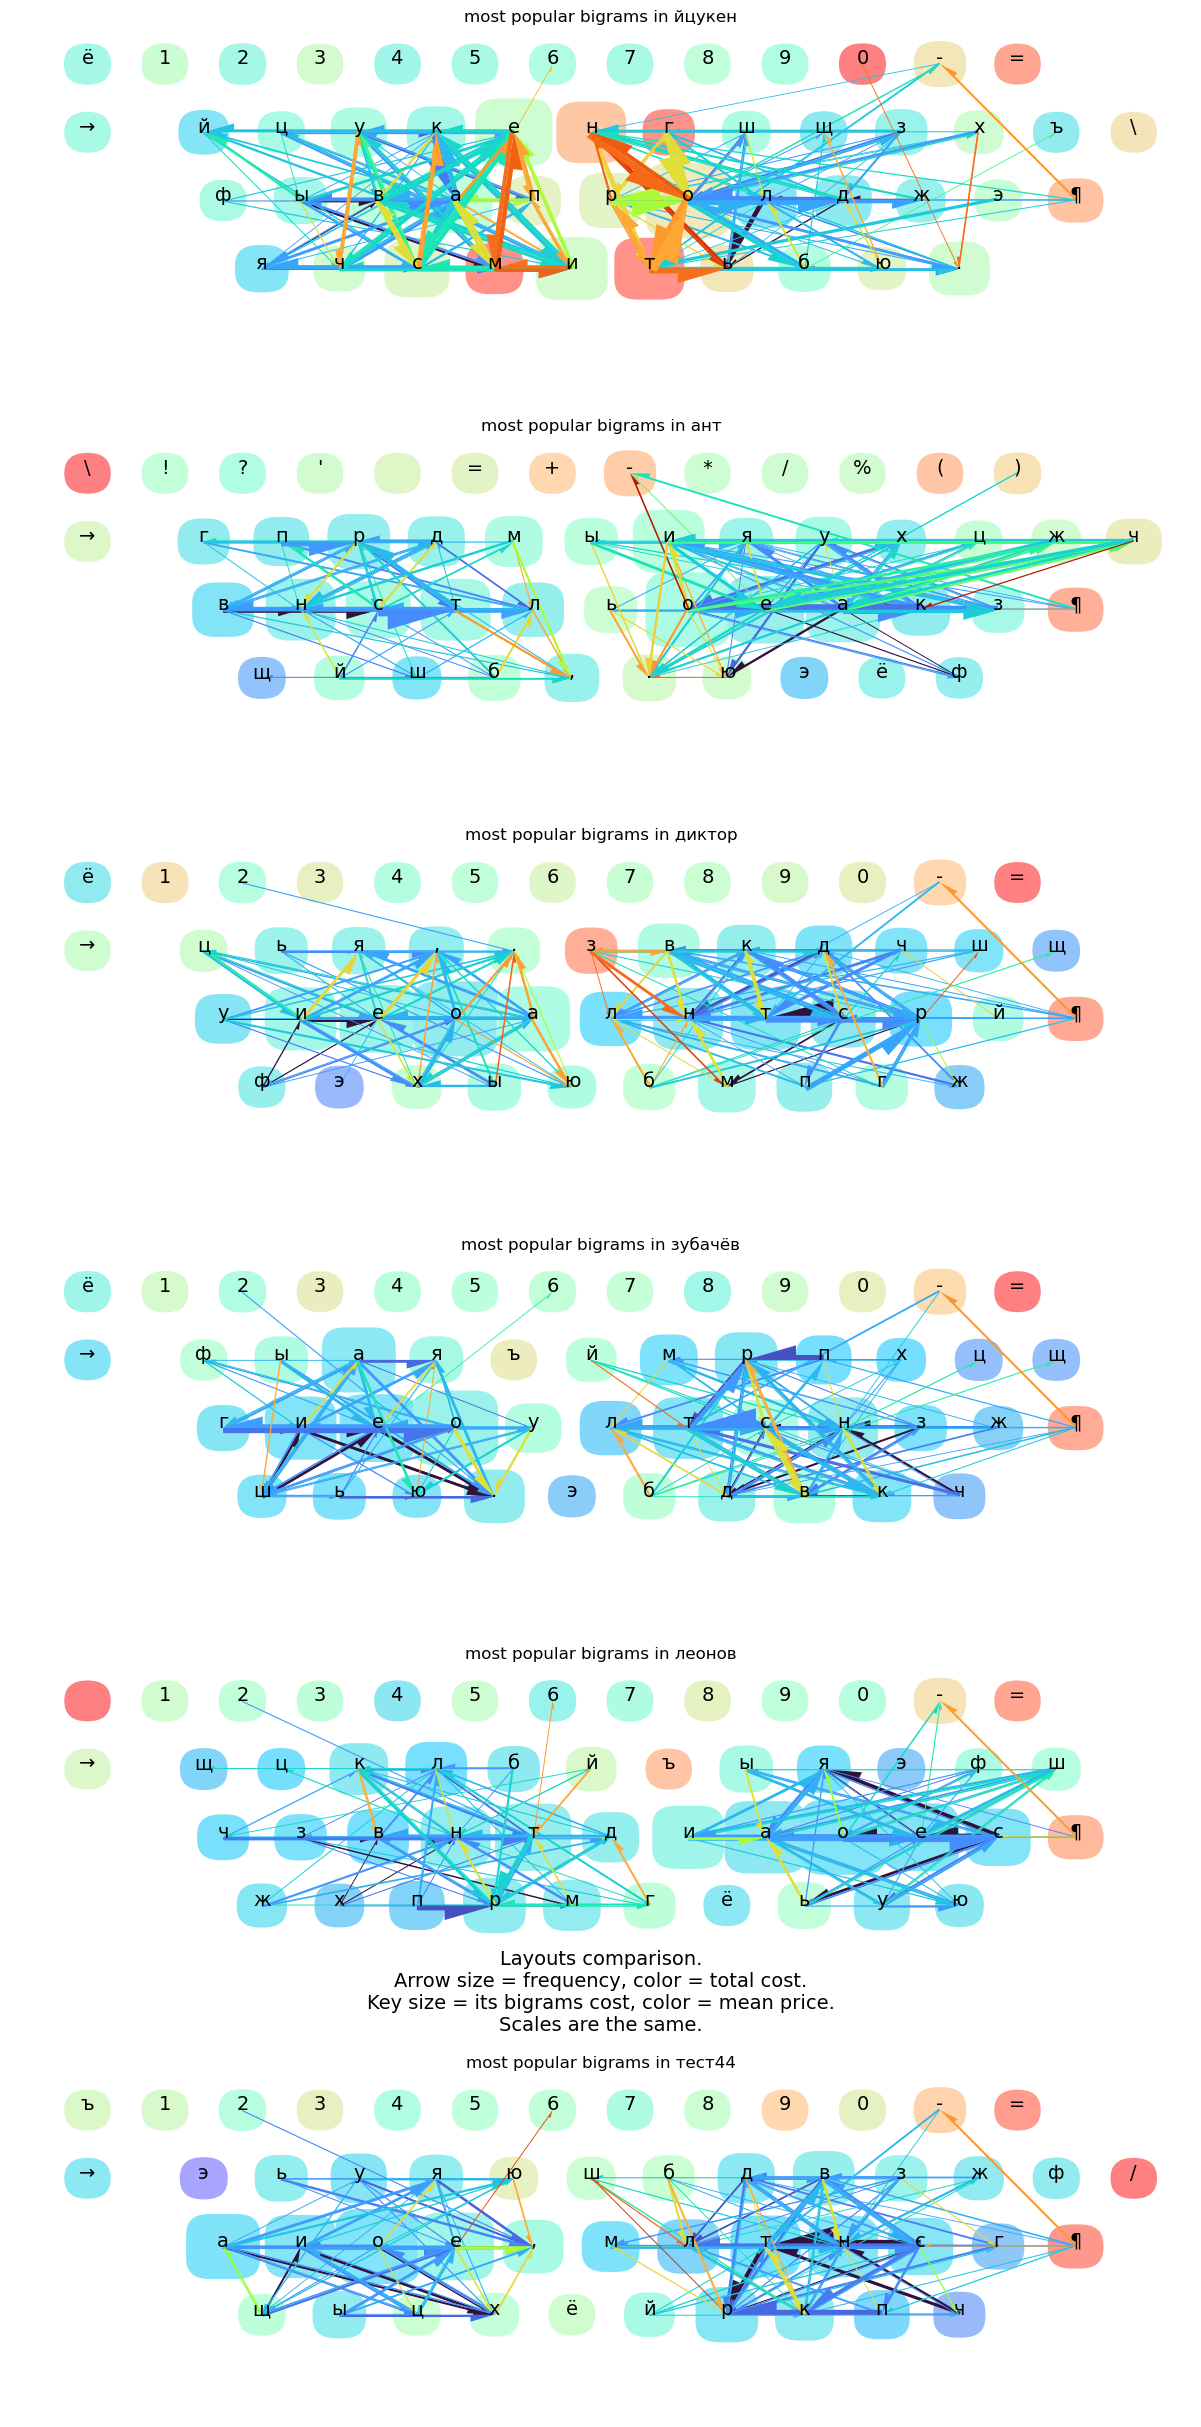

In [32]:
rs = results
rs['йцукен'].combomap(rs['ант'], rs['диктор'], rs['зубачёв'], rs['леонов'], rs[key])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

/usr/lib/python3/dist-packages/IPython/core/events.py:93: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  func(*args, **kwargs)


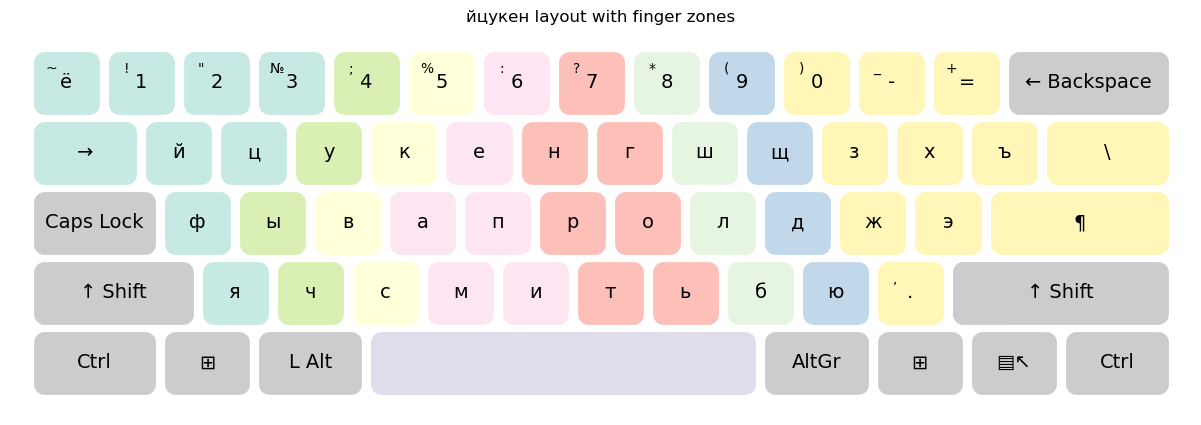

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9012 (\N{COUNTERBORE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


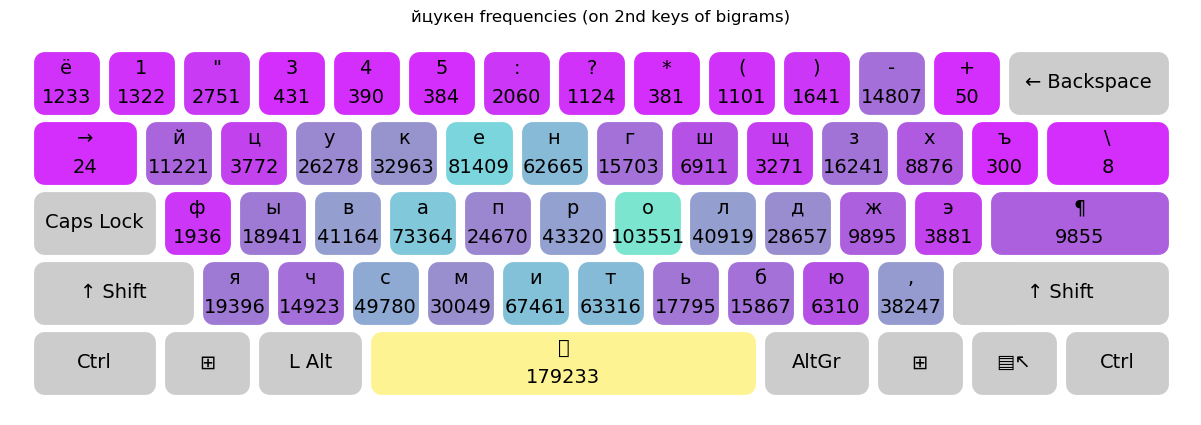

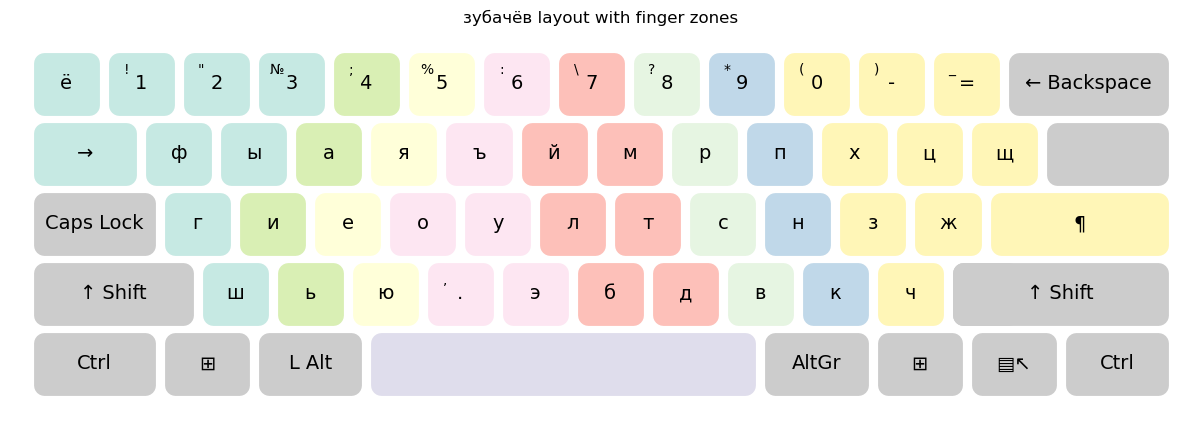

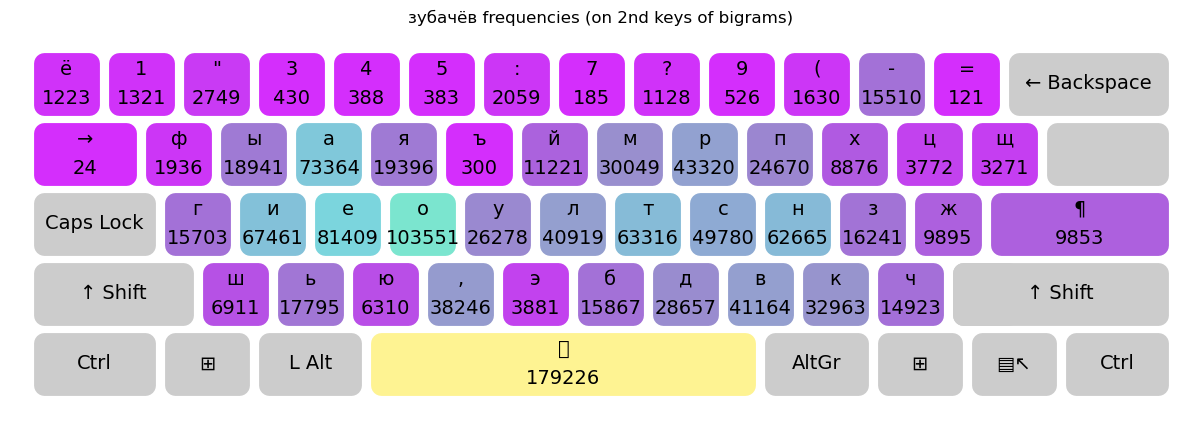

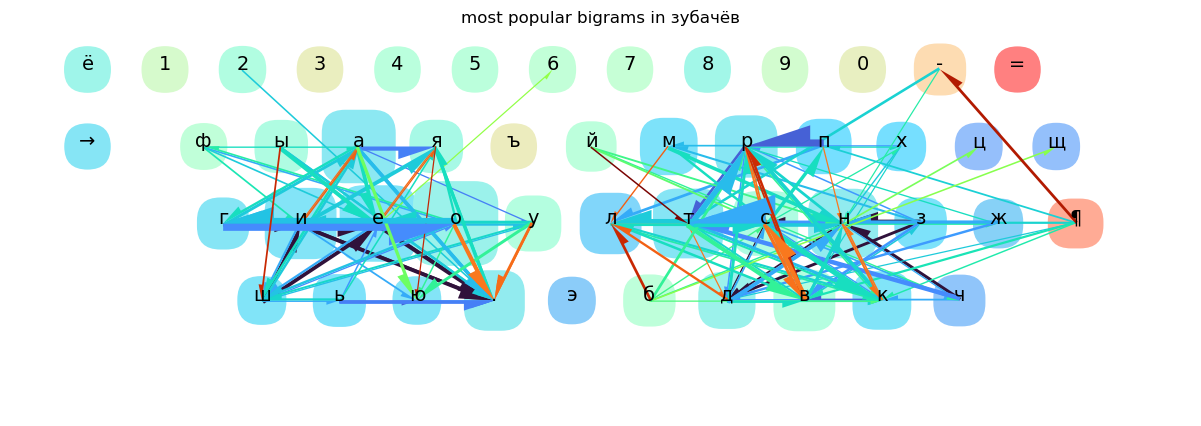

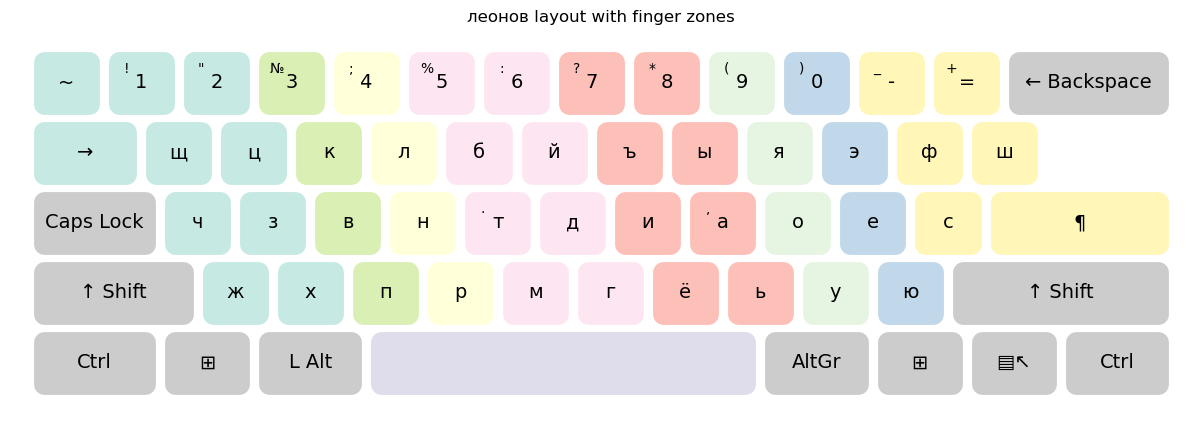

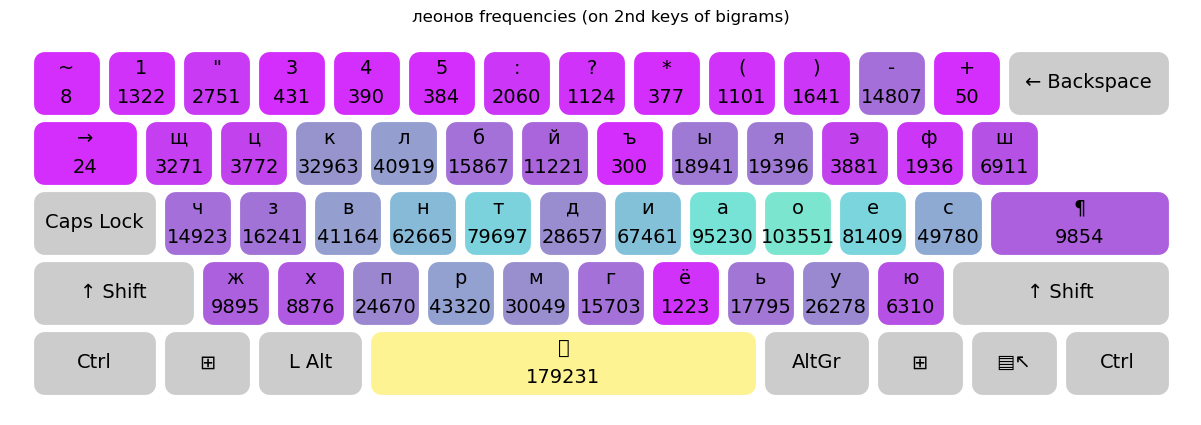

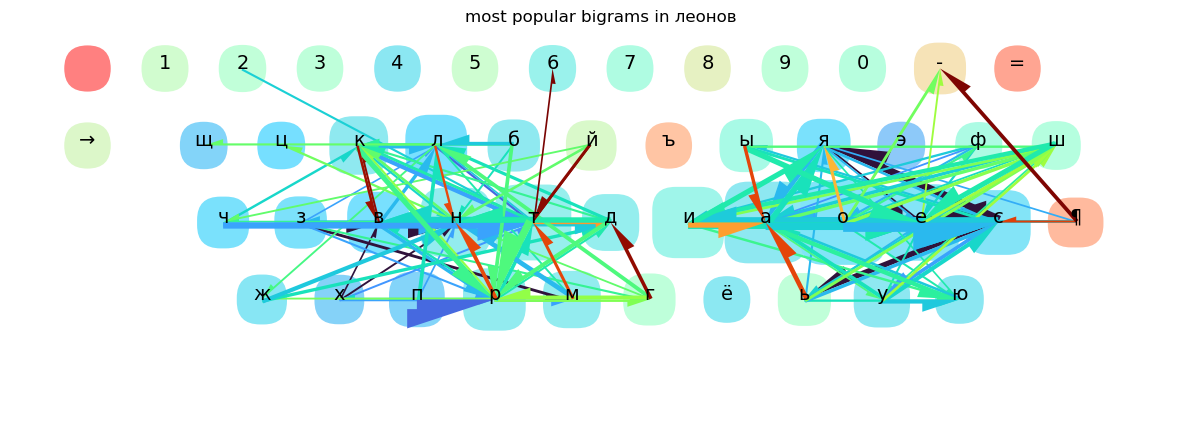

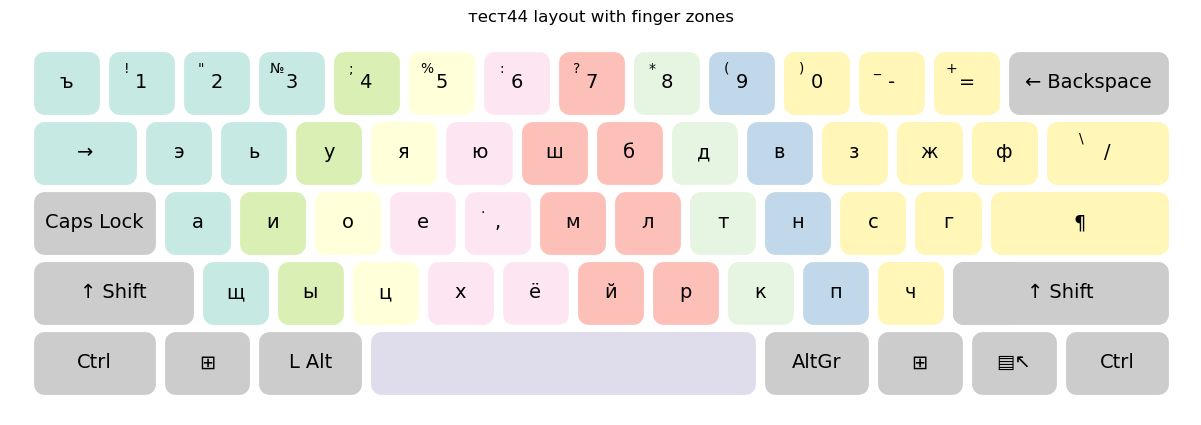

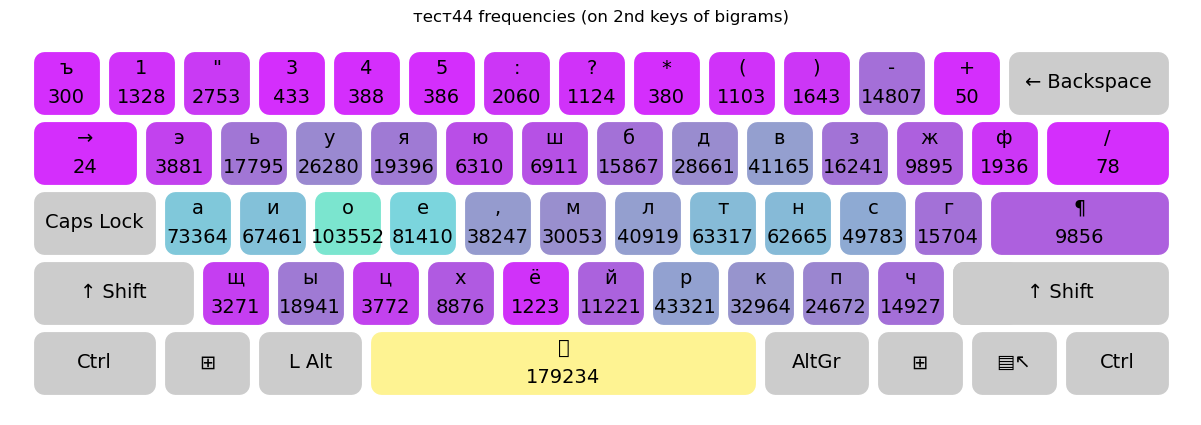

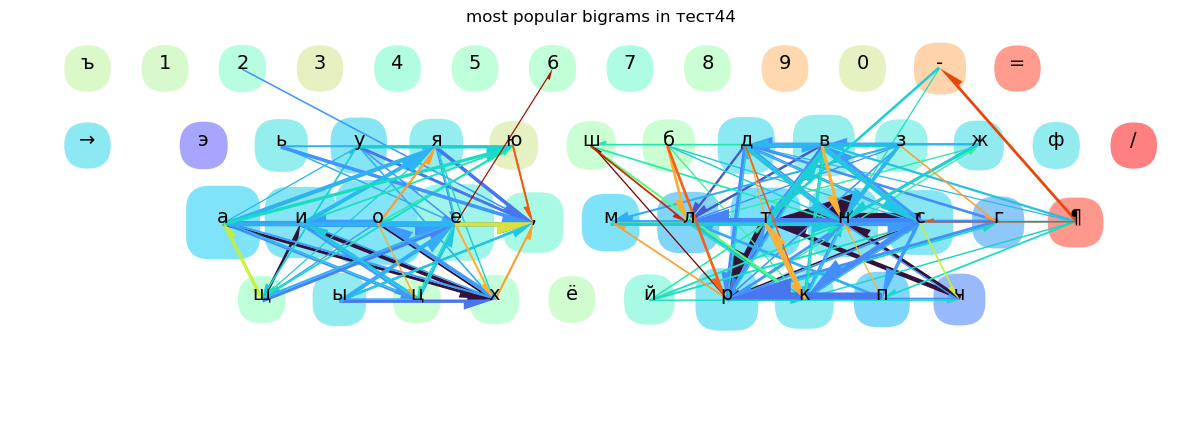

In [33]:
results['йцукен'].display('layout', 'num')
results['зубачёв'].display('layout', 'num', 'arrows')
results['леонов'].display('layout', 'num', 'arrows')
results[key].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [34]:
cmp = compare(results, 'леонов', key)
cmp.head(30)

bigram    num        row_cat_old  row_cost_old           col_cat_old  \
272     е,   2285                         0.666667                    ok   
186     вн   1452                         0.000000                    ok   
143     кт   1253                         0.666667                    ok   
324     бр   1031                         2.000000                    ok   
75      ,⌴  21854  alternating hands      0.000000  alternating or space   
346     бл   1031                         0.000000                    ok   
365     е.   1232  alternating hands      0.000000  alternating or space   
89      ⌴о   9887  alternating hands      0.000000  alternating or space   
285     шл    434  alternating hands      0.000000  alternating or space   
423     ю,    521                         1.333333                    ok   
141     ех    597  alternating hands      0.000000  alternating or space   
142     х,    520  alternating hands      0.000000  alternating or space   
307     тк    626                         0.666667                    ok   
182     ⌴э   3333  alternating hands      0.000000  alternating or space   
432     рш    240  alternating hands      0.000000  alternating or space   
463     вс   2892  alternating hands      0.000000  alternating or space   
149     .⌴   9908              thumb      0.000000                    ok   
138     я⌴   9423  alternating hands      0.000000  alternating or space   
497     ю.    307  alternating hands      0.000000  alternating or space   
146     рм    401                         1.000000                    ok   
561     е:    215  alternating hands      0.000000  alternating or space   
451     дк    352                         0.500000                    ok   
86      ⌴у   4177  alternating hands      0.000000  alternating or space   
191     ом   5523  alternating hands      0.000000  alternating or space   
242     ⌴е   3110  alternating hands      0.000000  alternating or space   
39      ь⌴   7467  alternating hands      0.000000  alternating or space   
871     ща    499  alternating hands      0.000000  alternating or space   
486     х.    301                         0.500000                    ok   
38      ть   6899  alternating hands      0.000000  alternating or space   
886     зг    344                         1.200000                    ok   

     col_cost_old  k2penalty_old  rollout_old  cost_old  \
272           0.0              1            0    6855.0   
186           0.0              0            0       0.0   
143           0.0              1            0    3759.0   
324           0.0              1            1   11341.0   
75            0.0              1            0   21854.0   
346           0.0              1            1    5155.0   
365           0.0              1            0    1232.0   
89            0.0              0            0       0.0   
285           0.0              1            0     434.0   
423           0.0              1            0    2605.0   
141           0.0              0            0       0.0   
142           0.0              1            0     520.0   
307           0.0              2            1    5008.0   
182           0.0              0            0       0.0   
432          -0.5              4            0     720.0   
463           0.0              0            0       0.0   
149           0.0              1            0    9908.0   
138           0.0              1            0    9423.0   
497           0.0              1            0     307.0   
146           0.0              0            0    1203.0   
561          -0.5              4            0     645.0   
451           1.0              2            1    3344.0   
86            0.0              1            0    4177.0   
191           0.0              0            0       0.0   
242           0.0              0            0       0.0   
39            0.0              1            0    7467.0   
871           0.0              1            0     499.

In [35]:
cmp.tail(30)

bigram    num              row_cat_old  row_cost_old  \
356     лн    411  same finger change rows          15.0   
537     йт    323  same finger change rows          20.0   
446     вк    302  same finger change rows          20.0   
225     ⌴б   6642                    thumb           0.0   
7       ли   7064        alternating hands           0.0   
61      ес   5318                                    0.0   
156     ис   3166                                    0.4   
148     т.    764  same finger change rows          10.0   
238     ас   4359                                    0.5   
458     кв    493  same finger change rows          20.0   
9       ⌴р   5184                    thumb           0.0   
79      ⌴г   4370                    thumb           0.0   
15      ни   8890        alternating hands           0.0   
56      ос   6755                                    0.0   
227     ⌴д   7563                    thumb           0.0   
422     м.    692  same finger change rows          15.0   
206     ы,    875  same finger change rows          15.0   
133     ⌴ч   5221                    thumb           0.0   
76      ⌴т   7734                    thumb           0.0   
440     й.    663  same finger change rows          20.0   
345     рн   1093  same finger change rows          15.0   
30      ⌴к   9125                    thumb           0.0   
78      тр   4206                                    2.0   
18      ⌴в  15759                    thumb           0.0   
190     а,   1911  same finger change rows          10.0   
301     гд    952  same finger change rows          20.0   
300     и,   2090  same finger change rows          10.0   
66      ⌴н  15954                    thumb           0.0   
40      ⌴п  16445                    thumb           0.0   
243     ь,   1616  same finger change rows          15.0   

              col_cat_old  col_cost_old  k2penalty_old  rollout_old  cost_old  \
356                    ok           0.0              0            0   18495.0   
537                    ok           1.0              1            0   20349.0   
446                    ok           0.0              2            0   18724.0   
225  alternating or space           0.0              1            1   33210.0   
7    alternating or space           0.5              2            0   21192.0   
61                     ok           0.0              0            1   21272.0   
156                    ok           1.0              0            1   22795.2   
148                    ok           0.0              1            0   23684.0   
238                    ok           0.0              0            1   23974.5   
458                    ok           0.0              0            0   29580.0   
9    alternating or space           0.0              1            1   25920.0   
79   alternating or space          -0.5              4            1   30590.0   
15   alternating or space           0.5              2            0   26670.0   
56                     ok           0.0              0            1   27020.0   
227  alternating or space          -0.5              2            1   37815.0   
422                    ok           0.0              1            0   31832.0   
206                    ok           0.0              1            0   40250.0   
133  alternating or space           0.5              2            1   36547.0   
76   alternating or space           0.0              1            1   38670.0   
440                    ok           1.0              1            0   41769.0   
345                    ok           0.0              0            0   49185.0   
30   alternating or space           0.0              2            1   54750.0   
78                     ok           0.0              1            1   46266.0   
18   alternating or space           0.0              0            1   63036.0   
190                    ok           0.0              1            0   59241.0   
301                    ok           0